In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
from tqdm.notebook import tqdm
from scipy.special import inv_boxcox

warnings.filterwarnings('default')
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


В приложенный к заданию файл добавлены данные по зарплате до марта 2021 ([источник: Росстат](https://rosstat.gov.ru/storage/mediabank/wh2stUhI/t2.xlsx))

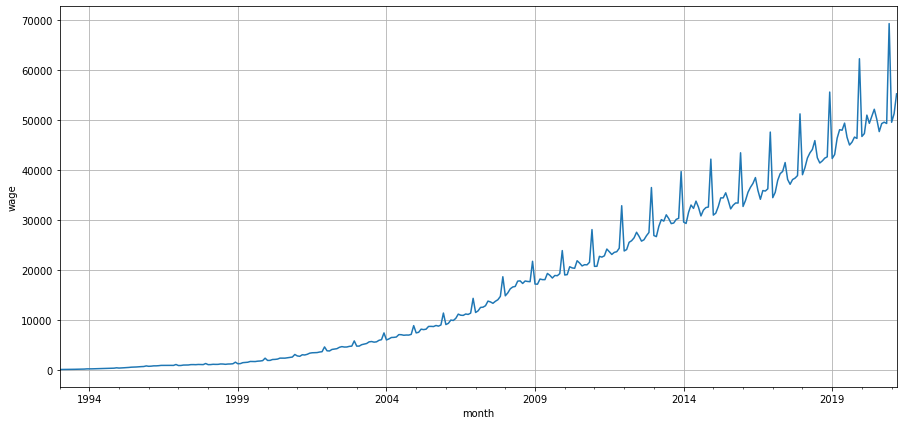

(339, 1)

In [2]:
dataurl = 'https://raw.githubusercontent.com/chekhovana/data/main/wages-2021.csv'
data = pd.read_csv(dataurl, ';', index_col=['month'], parse_dates=['month'], dayfirst=True)
data.columns = ['wage']
plt.figure(figsize(15,7))
data.wage.plot()
plt.ylabel('wage')
plt.xlabel('month')
plt.grid()
plt.show()
data.shape

Выделим данные за два последних года в тестовый датасет holdout, это даст нам возможность оценить качество прогноза нашей модели

In [3]:
holdout = data[-24:]
print(holdout.shape)
data = data[:-24]
print(data.shape)

(24, 1)
(315, 1)


Проверка стационарности и STL-декомпозиция ряда:

In [4]:
def test_plot_stl(data):
    print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data)[1])
    plt.figure(figsize(15,10))
    sm.tsa.seasonal_decompose(data).plot()
    plt.show()

Критерий Дики-Фуллера: p=0.998722


<Figure size 1080x720 with 0 Axes>

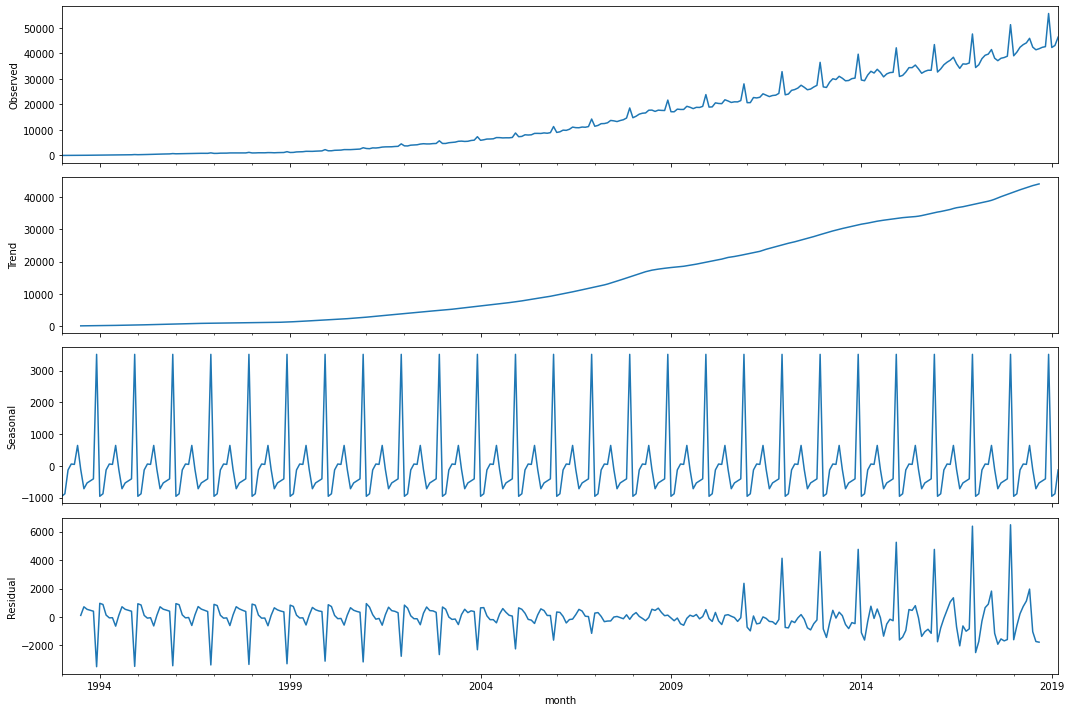

In [5]:
test_plot_stl(data.wage)

Наблюдаемый ряд нестационарен, поскольку:
<li>критерий Дики-Фуллера не отвергает гипотезу о нестационарности ряда
<li>визуально в данных прослеживается тренд и сезонность
<li>дисперсия остатков непостоянна

Требуется предобработка данных, преобразующая их в стационарный ряд.


### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.284347
Критерий Дики-Фуллера: p=0.762980


<Figure size 1080x720 with 0 Axes>

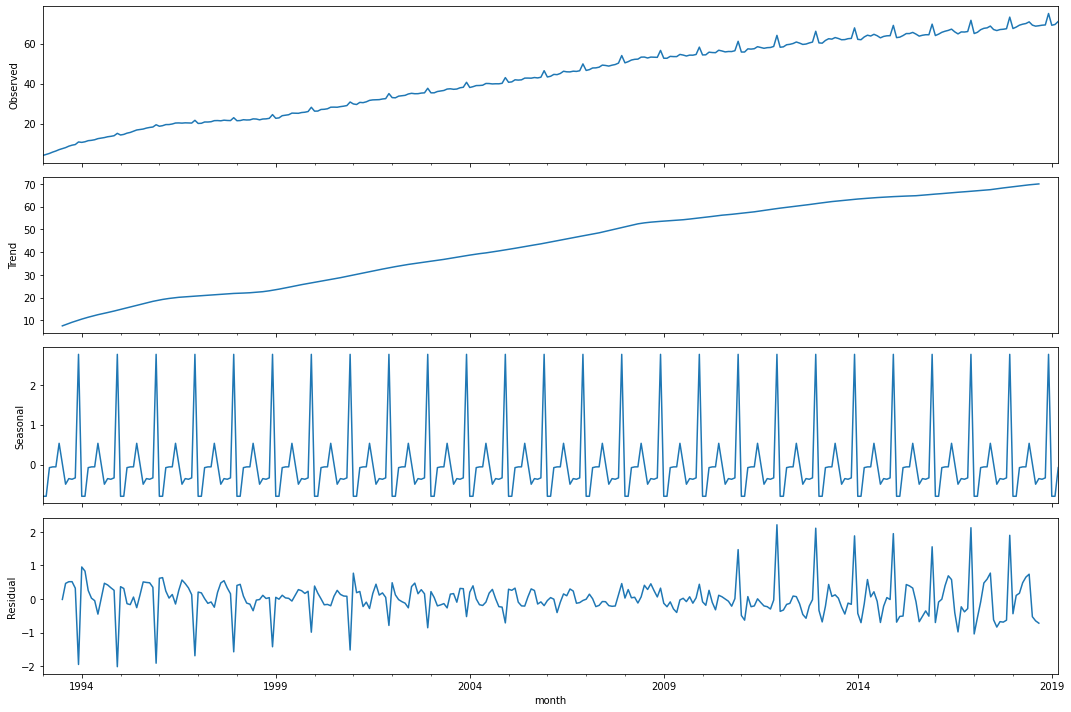

In [6]:
data['wage_box'], lmbda = stats.boxcox(data.wage)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
test_plot_stl(data.wage_box)

Критерий Дики-Фуллера по-прежнему не отвергает гипотезу о нестационарности, однако достигаемый уровень значимости заметно уменьшился. Это говорит о том, что с помощью преобразования Бокса-Кокса мы в некоторой степени снизили нестационарность ряда.

### Дифференцирование

Поскольку в ряде присутствует четко выраженный сезонный профиль, начнем с сезонного дифференцирования:

Критерий Дики-Фуллера: p=0.129384


<Figure size 1080x720 with 0 Axes>

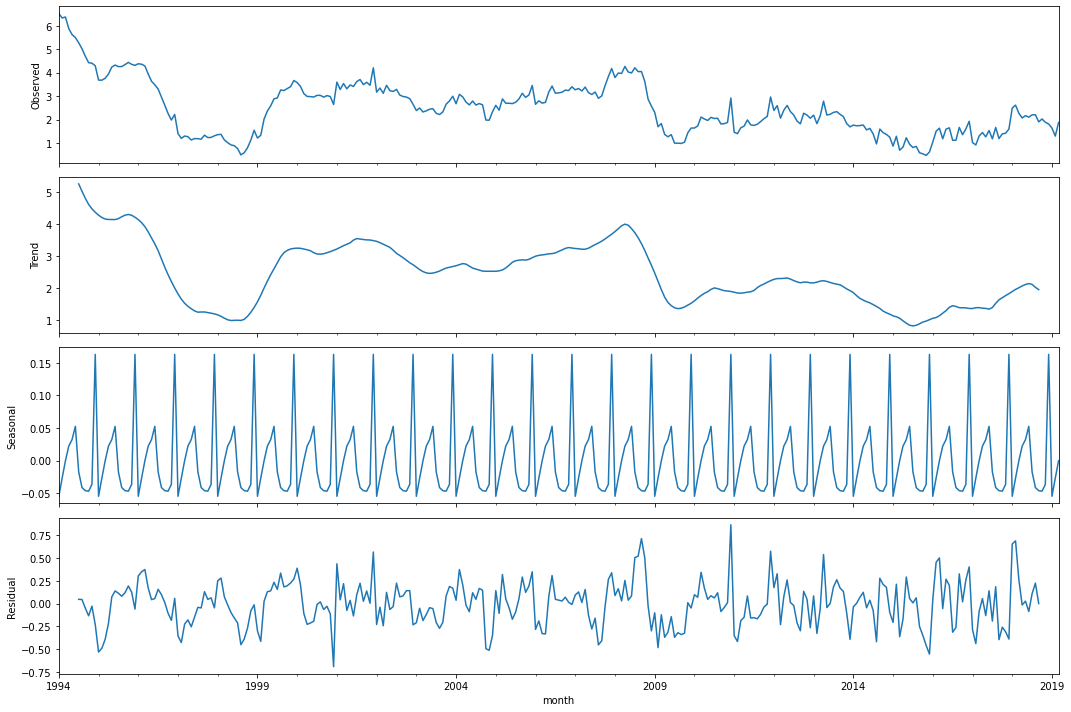

In [7]:
data['wage_diff'] = data.wage_box - data.wage_box.shift(12)
test_plot_stl(data.wage_diff.dropna())

Достигаемый уровень значимости критерия Дики-Фуллера снизился еще более существенно. Тем не менее, гипотеза нестационарности по-прежнему не отвергается. Тренд в данных также прослеживается визуально. Применим дополнительно обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

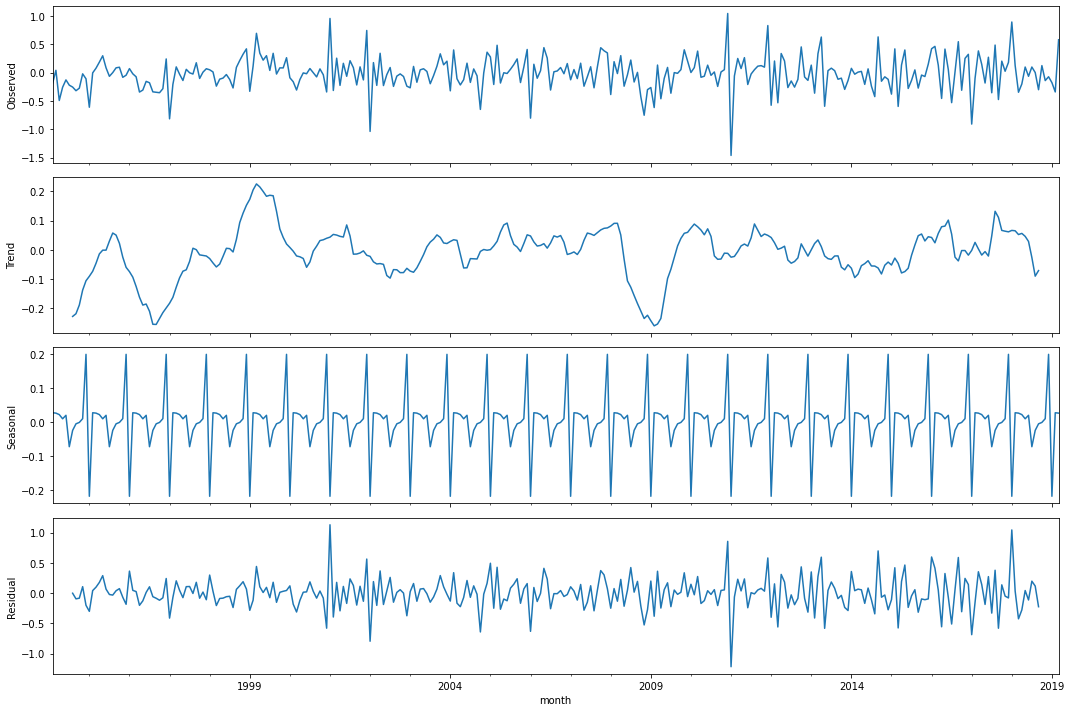

In [8]:
data['wage_diff2'] = data.wage_diff - data.wage_diff.shift(1)
test_plot_stl(data.wage_diff2.dropna())

Гипотеза нестационарности уверенно отвергается, визуально тренд в данных отсутствует. Таким образом, мы подобрали параметры нашей модели, задающие порядки дифференцирования: D = 1, d = 1

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

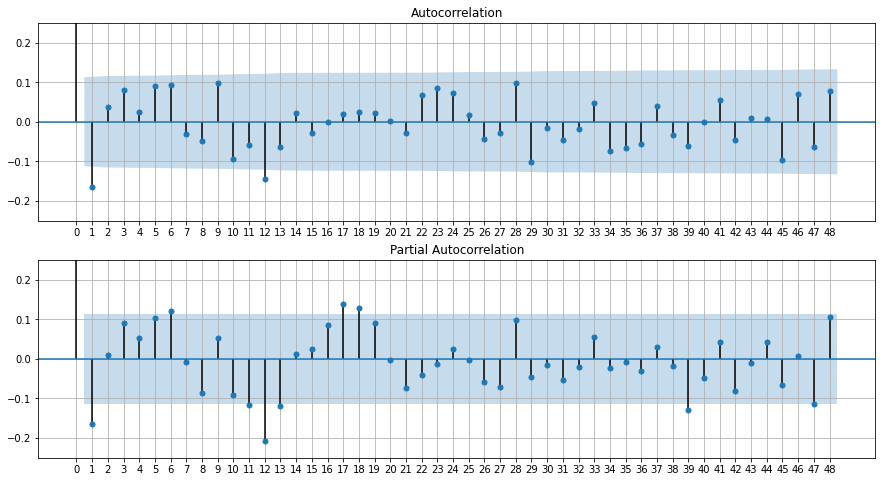

In [9]:
def customize_cf_plot(ax):
    ax.grid()
    ax.xaxis.set_ticks(np.arange(0, 49, 1))
    ax.set_ylim(-0.25, 0.25)

wage_diff2 = data.wage_diff2.dropna()
plt.figure(figsize(15,8))

for i, func in enumerate([sm.graphics.tsa.plot_acf, sm.graphics.tsa.plot_pacf]):
    ax = plt.subplot(2, 1, i + 1)
    func(wage_diff2, ax, 48)
    customize_cf_plot(ax)

pylab.show()

Подбираем по графику автокорреляции начальные приближения параметров Q, q: 
<li>значимые сезонные лаг: 12. Выбираем Q = 1
<li>значимые несезонные лаг: 1. Выбираем q = 1

Подбираем по графику частичной автокорреляции начальные приближения параметров P, p: 
<li>значимый сезонный лаг: 12. Выбираем P = 1
<li>значимые несезонные лаги: 1, 6, 11, 17, 39, 47. Выбираем p = 6.

При выборе начальных приближений параметра p принималось в расчет, что число параметров модели определяет ее сложность. 

p = 1 слишком мало, модель может получиться чрезмерно простой, недообученной.  Большие же значения p, с учетом небольшого объема имеющихся в наличии данных, создают риск переобучения модели. В результате было выбрано некоторое среднее значение.

In [10]:
D, d = 1, 1
Qs = Ps = qs = [0, 1, 2]
ps = [5, 6, 7]
params = list(product(ps, qs, Ps, Qs))
len(params)

81

In [11]:
results = []
best_result = {'aic': float(inf)}
for param in tqdm(params):
    p, q, P, Q = param
    try:
        model=sm.tsa.statespace.SARIMAX(data.wage_box, order=(p, d, q), 
            seasonal_order=(P, D, Q, 12)).fit(disp=-1)
        results.append([param, model.aic])
        if (model.aic < best_result['aic']):
            best_result = {'aic': model.aic, 'model': model, 'param': param}
    except (ValueError, LinAlgError):
        print('wrong parameters:', param)
        continue

results.sort(key=lambda x: x[1])
print(best_result)


{'aic': 103.90600178502552, 'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x7fd3f88d4f50>, 'param': (6, 2, 2, 2)}


In [12]:
df_results = pd.DataFrame(results)
df_results.columns = ['parameters', 'aic']
df_results.head()

,parameters,aic
0,"(6, 2, 2, 2)",103.906002
1,"(5, 2, 2, 2)",105.881471
2,"(5, 2, 1, 0)",107.405928
3,"(5, 2, 2, 0)",107.406206
4,"(5, 2, 0, 1)",108.174226


Наилучший результат дает следующий набор параметров:

p = 6, q = 2, P = 2, Q = 2

Характеристики лучшей модели:

In [13]:
best_model = best_result['model']
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           wage_box   No. Observations:                  315
Model:             SARIMAX(6, 1, 2)x(2, 1, 2, 12)   Log Likelihood                 -38.953
Date:                            Wed, 02 Jun 2021   AIC                            103.906
Time:                                    11:36:30   BIC                            152.142
Sample:                                01-01-1993   HQIC                           123.206
                                     - 03-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4222      0.082     17.440      0.000       1.262       1.582
ar.L2         -0.4848      0.108   

Её остатки:

Критерий Стьюдента: p = 0.7337049121868726
Критерий Дики-Фуллера: p = 1.0661479054440533e-29
Критерий Льюнга-Бокса: p = 0.7084078424906781


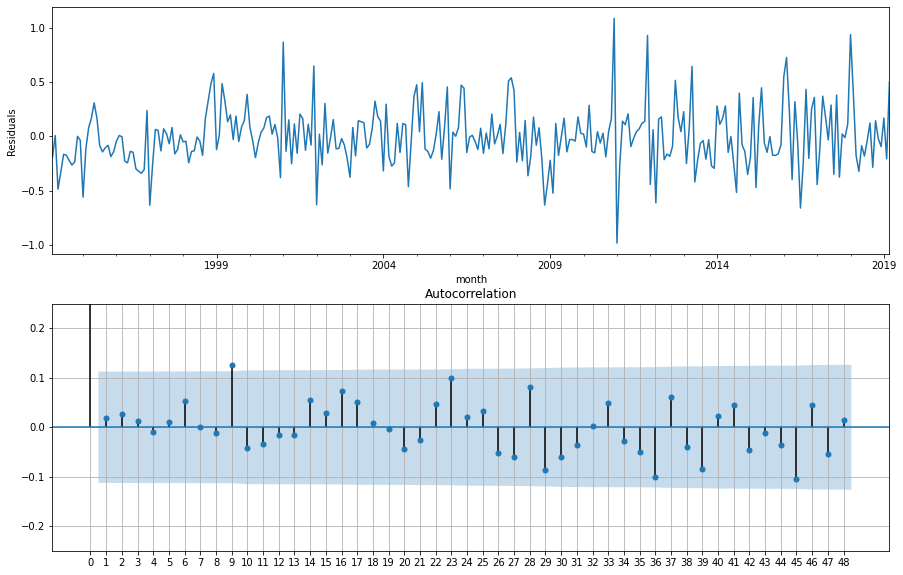

In [14]:
shift = 13 # это значение определяется порядками сезонного и обычного дифференцирования
residuals = best_model.resid[shift:]

plt.figure(figsize(15,10))
plt.subplot(211)
plt.grid()
residuals.plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
ax.set_ylim(-0.2, 0.2)
sm.graphics.tsa.plot_acf(residuals, lags=48, ax=ax)
customize_cf_plot(ax)

ttest_pvalue = stats.ttest_1samp(residuals, 0)[1]
adfuller_pvalue = sm.tsa.stattools.adfuller(residuals)[1]
ljungbox_pvalue = np.min(sm.stats.acorr_ljungbox(residuals, lags=24)[1])

print(f'Критерий Стьюдента: p = {ttest_pvalue}')
print(f'Критерий Дики-Фуллера: p = {adfuller_pvalue}')
print(f'Критерий Льюнга-Бокса: p = {ljungbox_pvalue}')

Количество лагов для критерия Льюнга-Бокса выбрано согласно рекомендации, изложенной в [статье](https://robjhyndman.com/hyndsight/ljung-box-test/):

n = 2 * m

где m - период сезона, в нашем случае он составляет 12

Остатки несмещены (подтверждается критерием Стьюдента), стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные обучающей выборки:

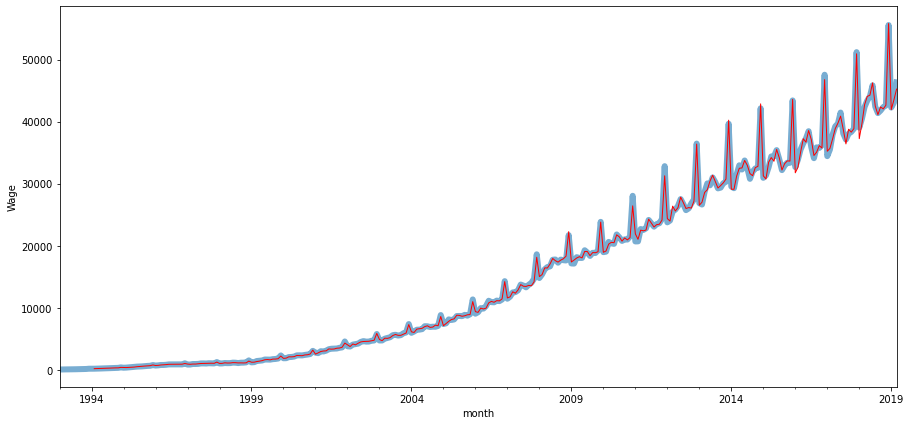

In [15]:
data['model'] = inv_boxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.wage.plot(alpha=0.6, linewidth=6)
data.model[13:].plot(color='r', linewidth=1)
plt.ylabel('Wage')
pylab.show()

### Прогноз

In [16]:
count = 24
date_from = data.index.max()
dates = [date_from + relativedelta(months=x) for x in range(1, count + 1)]

start_index = data.shape[0]
end_index = start_index + count - 1
predictions = best_model.predict(start=start_index, end=end_index)
future = pd.DataFrame(index=dates)
future['wage'] = inv_boxcox(predictions, lmbda)

Визуализируем полученные результаты. На первом графике отображаются все данные, включая обучающую выборку. На втором - только фактические данные и прогноз модели за последние два года.

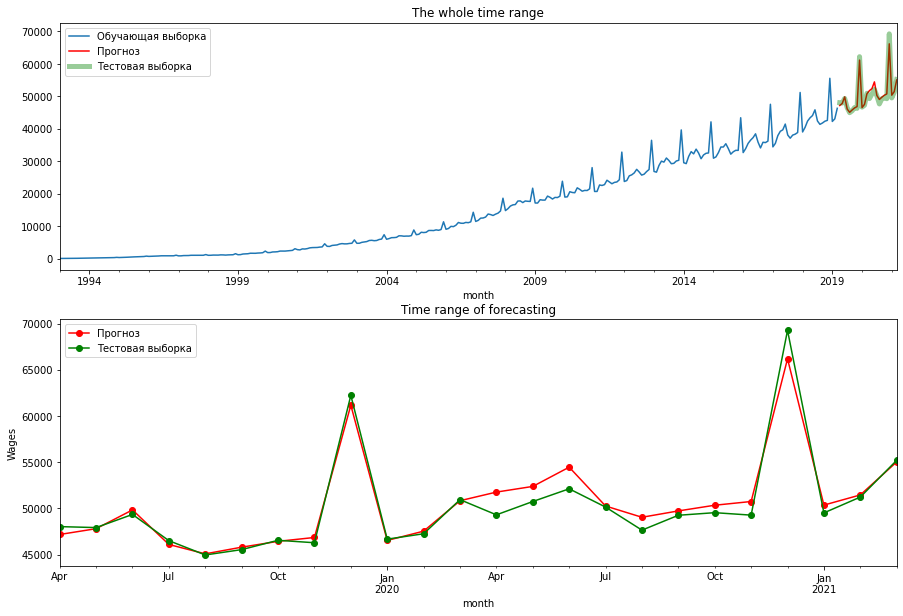

In [17]:
plt.figure(figsize(15, 10))
ax = plt.subplot(211)

data.wage.plot(label='Обучающая выборка')
future.wage.plot(color='r', label='Прогноз')
holdout.wage.plot(color='g', label='Тестовая выборка', alpha=0.4, linewidth=5)
ax.legend()
ax.set_title('The whole time range')

ax = plt.subplot(212)
future.wage.plot(color='r', marker='o', label='Прогноз', ax=ax)
holdout.wage.plot(color='g', marker='o', label='Тестовая выборка')
ax.legend()
plt.ylabel('Wages')
ax.set_title('Time range of forecasting')
pylab.show()

Вывод: полученная модель хорошо строит прогноз, визуально данный прогноз можно одобрить